In [ ]:
# base libraries
import numpy as np
import pandas as pd
import regex as re
import itertools
import sklearn.metrics as sk
from functools import reduce
from tqdm import tqdm
import matplotlib.pyplot as plt

# deep learning libraries
import torch
import transformers
from sklearn.model_selection import train_test_split
from simpletransformers.classification import ClassificationModel, ClassificationArgs

# hyperparameter optimization
import optuna
from optuna.samplers import TPESampler
import optuna.visualization.matplotlib as oviz

# file system manipulation
import os
import shutil
from pathlib import Path
import pickle
import copy

# logging
import logging
import time

In [ ]:
# set seeds to make computations deterministic
np.random.seed(42)
torch.manual_seed(42)

# check CUDA availability
cuda_available = torch.cuda.is_available()
print("Is CUDA available? ", "Yes" if cuda_available else "No")

In [ ]:
best_model = ClassificationModel(
    "bert",
    "Storage/Bert/NoHyperParameterTuningResults/trial_0"
)

In [ ]:
data = pd.read_csv(r"Storage/Bert/sample_8_12.csv")
data = data[["PatientID", "regex_sent"]]
data.columns = ["PatientID", "text"]
data.head()
sample_predictions = []
sample_outputs = []
chunk_size = 500
total_predicted = 0

for i in tqdm(range(int(len(data) / chunk_size))): 
    if (len(data) - total_predicted < chunk_size):        
        subset_predictions, subset_outputs = best_model.predict(
            data[total_predicted:]["text"].to_list()
        )
        assert len(subset_predictions) == len(subset_outputs)
        sample_predictions.append(subset_predictions)
        sample_outputs.append(subset_outputs)
    else:
        subset_predictions, subset_outputs = best_model.predict(
            data[chunk_size * i : chunk_size * (i+1)]["text"].to_list()
        )
        assert len(subset_predictions) == len(subset_outputs)
        sample_predictions.append(subset_predictions)
        sample_outputs.append(subset_outputs)
    total_predicted += len(subset_predictions)

    f = open("Storage/Bert/sample_predictions.pkl", "wb")
    pickle.dump(str(sample_predictions), f)
    f.close()

    f = open("Storage/Bert/sample_outputs.pkl", "wb")
    pickle.dump(sample_outputs, f)
    f.close()

In [108]:
max_prob_list = []
sample_prob_list = []

for i in range((373 * 500)):
    # prob_list = list(torch.softmax(torch.from_numpy(model_outputs[i]), axis=0)[:,1])
    prob_list = torch.softmax(torch.from_numpy(sample_outputs[i]), axis=0)
    #print("Prob List: ", prob_list, type(prob_list))

    extracted_prob_list = []
    for i in range(len(prob_list)):
        extracted_prob_list.append(float(prob_list[i]))

    #print("Extracted Prob List: ", extracted_prob_list)
    # find max one in each submatrix of length 3
    max_proba = max(extracted_prob_list)

    max_prob_list.append(max_proba)
    sample_prob_list.append(extracted_prob_list)


In [ ]:
preds, raw_outputs = best_model.predict(
    data[373 * 500:]["text"].to_list()
)

In [ ]:
sample_predictions = np.append(sample_predictions, preds)

In [109]:
for i in range((230)):
    # prob_list = list(torch.softmax(torch.from_numpy(model_outputs[i]), axis=0)[:,1])
    prob_list = torch.softmax(torch.from_numpy(raw_outputs[i]), axis=0)
    #print("Prob List: ", prob_list, type(prob_list))

    extracted_prob_list = []
    for i in range(len(prob_list)):
        extracted_prob_list.append(float(prob_list[i]))

    #print("Extracted Prob List: ", extracted_prob_list)
    # find max one in each submatrix of length 3
    max_proba = max(extracted_prob_list)

    max_prob_list.append(max_proba)
    sample_prob_list.append(extracted_prob_list)

In [110]:
len(sample_predictions), len(max_prob_list), len(sample_prob_list)

(186730, 186730, 186730)

In [111]:
data["pred"] = sample_predictions
data["proba"] = max_prob_list
data["three_class_proba"] = sample_prob_list

In [112]:
data.head()

,PatientID,text,pred,proba,three_class_proba
0,Z6352398,"""\""ession alone in the meta-analysis. We discu...",0,0.715272,"[0.7152721933151982, 0.17856770833522906, 0.10..."
1,Z6353136,"""\"" ------- l obstruction ASSOCIATED DIAGNOSES...",0,0.882016,"[0.8820158068779292, 0.040612868620269166, 0.0..."
2,Z6353461,"""\"" ------- (156 lb) 09/19/17 71.4 kg (157 lb...",0,0.996410,"[0.9964098411341745, 0.0020475801064918607, 0...."
3,Z6353764,"""\""ut answer. Optho notes from recent outpatie...",0,0.660061,"[0.660060746600553, 0.15816217546250927, 0.181..."
4,Z6354111,"""\""hat would be more consistent. Has been aler...",2,0.627863,"[0.2079084264007656, 0.16422835721082146, 0.62..."


In [113]:
data.to_csv(r"Storage/Bert/sample_preds.csv", index = False)

In [69]:
apoe = pd.read_csv(r"Storage/Bert/tanish_predictions_with_structured_features.csv")

In [70]:
data_apoe = data.copy()
data_apoe = pd.merge(data_apoe, apoe, how = "right", on = "PatientID")

In [71]:
e_2 = data_apoe[(data_apoe["APOE"] == "e2/e2") | (data_apoe["APOE"] == "e2/e3")]
e_3 = data_apoe[(data_apoe["APOE"] == "e3/e3")]
e_4 = data_apoe[(data_apoe["APOE"] == "e4/e4") | (data_apoe["APOE"] == "e2/e4 or e1/e3") | (data_apoe["APOE"] == "e3/e4")]

In [74]:
def percent_ci(df, sequence_threshold):
    patient_level_preds = []
    p_id_ls = []
    ci_count = 0
    for p_id in df["PatientID"].unique():
        sequences = df[df["PatientID"] == p_id]
        if len(sequences[sequences["pred"] == 2]) >= sequence_threshold:
            patient_level_preds.append(1)
            ci_count += 1
        else:
            patient_level_preds.append(0)
        p_id_ls.append(p_id)
    return patient_level_preds, ci_count/len(df["PatientID"].unique()), p_id_ls

In [75]:
x_axis = []
y_axis_e2 = []; y_axis_e3 = []; y_axis_e4 = []
e2_preds = []; e3_preds = []; e4_preds = []
e2_pid = []; e3_pid = []; e4_pid = []

for i in tqdm(range(10)):
    e_2_preds, e_2_percent, e_2_p_id = percent_ci(e_2, i+1)
    e_3_preds, e_3_percent, e_3_p_id = percent_ci(e_3, i+1)
    e_4_preds, e_4_percent, e_4_p_id = percent_ci(e_4, i+1)
    
    x_axis.append(i+1)
    y_axis_e2.append(e_2_percent); y_axis_e3.append(e_3_percent); y_axis_e4.append(e_4_percent)
    e2_preds.append(e_2_preds); e3_preds.append(e_3_preds); e4_preds.append(e_4_preds)
    e2_pid.append(e_2_p_id); e3_pid.append(e_3_p_id); e4_pid.append(e_4_p_id)

100%|██████████| 10/10 [09:16<00:00, 55.62s/it]


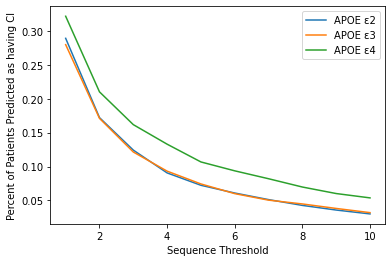

In [76]:
plt.plot(x_axis, y_axis_e2, label = 'APOE ε2')
plt.plot(x_axis, y_axis_e3, label = 'APOE ε3')
plt.plot(x_axis, y_axis_e4, label = 'APOE ε4')

plt.xlabel("Sequence Threshold")
plt.ylabel("Percent of Patients Predicted as having CI")
plt.legend(loc='best')
plt.show()

In [116]:
e_2_preds, e_2_percent, e_2_p_id = percent_ci(e_2, 2)
e_3_preds, e_3_percent, e_3_p_id = percent_ci(e_3, 2)
e_4_preds, e_4_percent, e_4_p_id = percent_ci(e_4, 2)

In [117]:
e_2_percent, e_3_percent, e_4_percent

(0.17217787913340935, 0.17106616386698664, 0.210128055878929)

In [98]:
len(e_2_p_id) + len(e_3_p_id) + len(e_4_p_id), len(e_2_preds) + len(e_3_preds) + len(e_4_preds)

(13941, 13941)

In [99]:
patient_preds = pd.DataFrame()
patient_preds["PatientID"] = (e_2_p_id) + (e_3_p_id) + (e_4_p_id)

In [101]:
patient_preds["Pred"] = (e_2_preds) + (e_3_preds) + (e_4_preds)

In [102]:
patient_preds = pd.merge(apoe, patient_preds, how = "right", on = "PatientID")

In [103]:
patient_preds.drop(columns = ["patient_CI"])

,PatientID,num_sequences_patient,EMPI,Dx_Count,Med_Count,AD_Med_or_ICD_Code,APOE,Pred
0,Z6354527,2,100002765,0,0,0,e2/e3,0
1,Z6357384,1,100006119,0,0,0,e2/e3,0
2,Z6358782,1,100007763,0,0,0,e2/e3,0
3,Z6359488,16,100008569,19,0,1,e2/e3,1
4,Z6359758,25,100008870,0,0,0,e2/e3,0
...,...,...,...,...,...,...,...,...
13936,Z15306032,1,111523532,0,0,0,e4/e4,0
13937,Z15426107,6,112157856,8,0,1,e3/e4,0
13938,Z15538190,1,112478766,0,0,0,e3/e4,0
13939,Z15769512,3,113093596,0,0,0,e3/e4,0


In [105]:
TP = len(patient_preds[(patient_preds["Pred"] == 1) & (patient_preds["AD_Med_or_ICD_Code"] == 1)])
FP = len(patient_preds[(patient_preds["Pred"] == 1) & (patient_preds["AD_Med_or_ICD_Code"] == 0)])
TN = len(patient_preds[(patient_preds["Pred"] == 0) & (patient_preds["AD_Med_or_ICD_Code"] == 0)])
FN = len(patient_preds[(patient_preds["Pred"] == 0) & (patient_preds["AD_Med_or_ICD_Code"] == 1)])

In [106]:
(TP, FP, TN, FN)

(1010, 827, 11365, 739)

In [107]:
patient_preds.to_csv(r"patient_level_bert_preds.csv", index = False)

In [10]:
import pandas as pd
pp = pd.read_csv(r"Storage/Bert/patient_level_bert_preds.csv")

In [11]:
pp

,PatientID,patient_CI,num_sequences_patient,EMPI,Dx_Count,Med_Count,AD_Med_or_ICD_Code,APOE,Pred
0,Z6354527,0,2,100002765,0,0,0,e2/e3,0
1,Z6357384,0,1,100006119,0,0,0,e2/e3,0
2,Z6358782,0,1,100007763,0,0,0,e2/e3,0
3,Z6359488,1,16,100008569,19,0,1,e2/e3,1
4,Z6359758,1,25,100008870,0,0,0,e2/e3,0
...,...,...,...,...,...,...,...,...,...
13936,Z15306032,1,1,111523532,0,0,0,e4/e4,0
13937,Z15426107,1,6,112157856,8,0,1,e3/e4,0
13938,Z15538190,1,1,112478766,0,0,0,e3/e4,0
13939,Z15769512,1,3,113093596,0,0,0,e3/e4,0


In [12]:
e_2 = pp[(pp["APOE"] == "e2/e2") | (pp["APOE"] == "e2/e3")]
e_3 = pp[(pp["APOE"] == "e3/e3")]
e_4 = pp[(pp["APOE"] == "e4/e4") | (pp["APOE"] == "e2/e4 or e1/e3") | (pp["APOE"] == "e3/e4")]

In [6]:
e_4_diff = e_4[(e_4["patient_CI"] == 1) & (e_4["AD_Med_or_ICD_Code"] == 0)]

,PatientID,patient_CI,num_sequences_patient,EMPI,Dx_Count,Med_Count,AD_Med_or_ICD_Code,APOE,Pred
10508,Z6361344,1,1,100010714,0,0,0,e3/e4,0
10515,Z6364579,1,29,100014427,0,0,0,e3/e4,1
10516,Z6365241,1,1,100015202,0,0,0,e4/e4,0
10528,Z6398328,1,5,100031034,0,0,0,e3/e4,0
10529,Z6412737,1,9,100036679,0,0,0,e3/e4,0
...,...,...,...,...,...,...,...,...,...
13923,Z9599375,1,1,108587200,0,0,0,e3/e4,0
13936,Z15306032,1,1,111523532,0,0,0,e4/e4,0
13938,Z15538190,1,1,112478766,0,0,0,e3/e4,0
13939,Z15769512,1,3,113093596,0,0,0,e3/e4,0


In [13]:
seqs = pd.read_csv(r"Storage/Bert/sample_preds.csv")

In [17]:
seqs[seqs["PatientID"] == e_4_diff.at[[10508, "PatientID"]]

SyntaxError: unexpected EOF while parsing (1463570047.py, line 1)